In [103]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [104]:
df = pd.read_csv('outfits.csv')

# forward fill missing values
df = df.ffill()

# drop column '#'
df = df.drop(columns=['#'])

# normalise column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# convert dates
# strip spaces, normalise commas
df["date"] = df["date"].str.strip()
df["date"] = df["date"].str.replace(r"\s*,\s*", ",", regex=True)  # ensure exactly one comma, no spaces around


df["date"] = pd.to_datetime(df["date"], format="%B %d,%Y")
df['month'] = df['date'].dt.month
df['dayofweek'] = df['date'].dt.dayofweek

# split city, state, country
# if 2 commas - city, state, country
# if 1 comma - city, country
def split_city(x):
    parts = [p.strip() for p in x.split(',')]
    if len(parts) == 3:
        return pd.Series({'city': parts[0], 'state': parts[1], 'country': parts[2]})
    elif len(parts) == 2:
        return pd.Series({'city': parts[0], 'state': None, 'country': parts[1]})
    else:  # fallback
        return pd.Series({'city': parts[0], 'state': None, 'country': None})

df[['city', 'state', 'country']] = df['city'].apply(split_city)

# add column for tour leg - 1 before may 9, 2024, 2 after
df['tour_leg'] = np.where(df['date'] < pd.to_datetime("2024-05-09"), 1, 2)

df.head()

,city,date,lover_bodysuit,lover_jacket,lover_guitar,fearless_dress,evermore,red_t-shirt,red_guitar,speak_now,...,coverall,surprise_song,midnights_shirt,bodysuit,karma_jacket,month,dayofweek,state,country,tour_leg
0,Glendale,2023-03-17,Pink and Blue,Silver,Purple,Fringe,Orange,A Lot,Red,Champagne,...,0,Pink,Silver Sequin,Navy,Multicolor,3,4,Arizona,USA,1
1,Glendale,2023-03-18,Blue and Gold,Black,Blue,Gold Noodle,Orange,TS - EW,Red,Pink Ball Gown,...,0,Green,Blue,Navy,Magenta,3,5,Arizona,USA,1
2,Las Vegas,2023-03-24,Pink and Blue,Silver,Purple,Fringe,Orange,A Lot,Red,Champagne,...,0,Pink,Silver Sequin,Blurple,Multicolor,3,4,Nevada,USA,1
3,Las Vegas,2023-03-25,Blue and Gold,Black,Pink,Gold Noodle,Orange,TS - EW,Red,Pink Ball Gown,...,0,Green,Blue,Navy,Pink,3,5,Nevada,USA,1
4,Arlington,2023-03-31,Blue and Gold,Black,Blue,Gold Noodle,Orange,WANEGBT,Red,Champagne,...,0,Green,Pink,Blurple,Multicolor,3,4,Texas,USA,1


In [105]:
# additional features
df['night_number'] = df.groupby('city').cumcount() + 1
df['overall_show_number'] = df.reset_index().index + 1

# previous night's lover bodysuit color
df['prev_lover_bodysuit'] = df.groupby('city')['lover_bodysuit'].shift(1)

# Fill first-night Bodysuit with the most common first-night Bodysuit in each city
def fill_first_night(group):
    first_show_bodysuit = group['lover_bodysuit'].iloc[0]
    group['prev_lover_bodysuit'] = group['prev_lover_bodysuit'].fillna(first_show_bodysuit)
    return group

df = df.groupby('city').apply(fill_first_night)


/var/folders/58/mnvdyggs7fzf7nl8xxs1fs5w0000gn/T/ipykernel_73808/1946424644.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('city').apply(fill_first_night)


In [106]:
lover_bodysuit_release_dates = {
    'Pink and Blue': "2023-03-17",
    'Blue and Gold': "2023-03-18",
    'Purple Tassels': "2023-05-27", 
    'Barbie Pink': "2023-11-09",
    'Orange and Pink': "2024-05-09"
}

In [ ]:
# -----------------------------
# Sort and reset
# -----------------------------
df = df.sort_values('date').reset_index(drop=True)
X = df[['city', 'month', 'dayofweek', 'night_number', 'overall_show_number',
        'prev_lover_bodysuit', 'state', 'country', 'tour_leg']]
y = df['lover_bodysuit']

# -----------------------------
# Encode features
# -----------------------------
X = pd.get_dummies(X, columns=['city', 'state', 'country', 'prev_lover_bodysuit'], drop_first=True)

# -----------------------------
# Encode target
# -----------------------------
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# -----------------------------
# Time-based k-fold validation
# -----------------------------
n_splits = 5
dates = df['date'].sort_values().unique()
chunk_size = len(dates) // n_splits

accuracies = []

for k in range(n_splits - 1):
    # Train on chunk k, test on chunk k+1
    train_dates = dates[k*chunk_size : (k+1)*chunk_size]
    test_dates = dates[(k+1)*chunk_size : (k+2)*chunk_size]

    train_mask = df['date'].isin(train_dates)
    test_mask = df['date'].isin(test_dates)

    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y_encoded[train_mask], y_encoded[test_mask]

    # Train model
    clf = RandomForestClassifier(n_estimators=200, random_state=42)
    clf.fit(X_train, y_train)

    # Predict
    y_pred = clf.predict(X_test)

    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Fold {k+1} accuracy: {acc:.3f}")

print("Mean accuracy:", np.mean(accuracies))


Fold 1 accuracy: 0.600
Fold 2 accuracy: 0.567
Fold 3 accuracy: 0.333
Fold 4 accuracy: 0.433
Mean accuracy: 0.4833333333333333


In [ ]:
all_results = []

for k in range(n_splits - 1):
    # Train on chunk k, test on chunk k+1
    train_dates = dates[k*chunk_size : (k+1)*chunk_size]
    test_dates = dates[(k+1)*chunk_size : (k+2)*chunk_size]

    train_mask = df['date'].isin(train_dates)
    test_mask = df['date'].isin(test_dates)

    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y_encoded[train_mask], y_encoded[test_mask]

    # Train model
    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)

    # Predict
    y_pred = clf.predict(X_test)

    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    print(f"Fold {k+1} accuracy: {acc:.3f}")

    # -----------------------------
    # Save results for inspection
    # -----------------------------
    fold_results = pd.DataFrame({
        'fold': k+1,
        'date': df.loc[test_mask, 'date'],
        'city': df.loc[test_mask, 'city'],
        'night_number': df.loc[test_mask, 'night_number'],
        'true_bodysuit': le.inverse_transform(y_test),
        'pred_bodysuit': le.inverse_transform(y_pred)
    })
    fold_results['correct'] = fold_results['true_bodysuit'] == fold_results['pred_bodysuit']
    
    all_results.append(fold_results)

# Combine all folds
results = pd.concat(all_results, ignore_index=True)

# Filter misclassified
misclassified = results[results['correct'] == False]

print(f"Number of misclassified rows: {len(misclassified)}")
misclassified.head(62)


Fold 1 accuracy: 0.567
Fold 2 accuracy: 0.500
Fold 3 accuracy: 0.300
Fold 4 accuracy: 0.433
Number of misclassified rows: 66


,fold,date,city,night_number,true_bodysuit,pred_bodysuit,correct
0,1,2023-06-04,Chicago,3,Blue and Gold,Purple Tassels,False
5,1,2023-06-23,Minneapolis,1,Blue and Gold,Pink and Blue,False
6,1,2023-06-24,Minneapolis,2,Purple Tassels,Pink and Blue,False
9,1,2023-07-07,Kansas City,1,Purple Tassels,Pink and Blue,False
10,1,2023-07-08,Kansas City,2,Pink and Blue,Purple Tassels,False
...,...,...,...,...,...,...,...
103,4,2024-08-20,London,8,Orange and Pink,Pink and Blue,False
104,4,2024-10-18,Miami,1,Orange and Pink,Pink and Blue,False
105,4,2024-10-19,Miami,2,Blue and Gold,Pink and Blue,False
106,4,2024-10-20,Miami,3,Purple Tassels,Orange and Pink,False


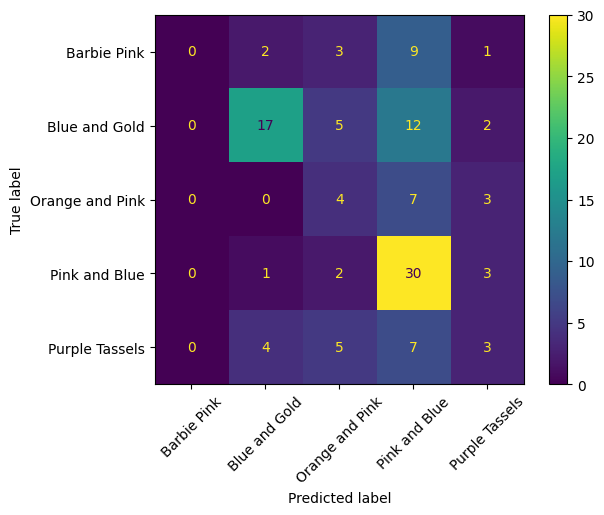

In [128]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(results['true_bodysuit'], results['pred_bodysuit'], labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=45)
plt.show()


In [137]:
# Lover jacket prediction model
df['prev_lover_jacket'] = df.groupby('city')['lover_jacket'].shift(1)

# -----------------------------
# Sort and reset
# -----------------------------
df = df.sort_values('date').reset_index(drop=True)
X = df[['city', 'month', 'dayofweek', 'night_number', 'overall_show_number',
        'prev_lover_bodysuit', 'prev_lover_jacket', 'state', 'country', 'tour_leg']]
y = df['lover_jacket']

# -----------------------------
# Encode features
# -----------------------------
X = pd.get_dummies(X, columns=['city', 'state', 'country', 'prev_lover_bodysuit', 'prev_lover_jacket'], drop_first=True)

# -----------------------------
# Encode target
# -----------------------------
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# -----------------------------
# Time-based k-fold validation
# -----------------------------
n_splits = 5
dates = df['date'].sort_values().unique()
chunk_size = len(dates) // n_splits

accuracies = []

for k in range(n_splits - 1):
    # Train on chunk k, test on chunk k+1
    train_dates = dates[k*chunk_size : (k+1)*chunk_size]
    test_dates = dates[(k+1)*chunk_size : (k+2)*chunk_size]

    train_mask = df['date'].isin(train_dates)
    test_mask = df['date'].isin(test_dates)

    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y_encoded[train_mask], y_encoded[test_mask]

    # Train model
    clf = RandomForestClassifier(n_estimators=200, random_state=42)
    clf.fit(X_train, y_train)

    # Predict
    y_pred = clf.predict(X_test)

    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Fold {k+1} accuracy: {acc:.3f}")

print("Mean accuracy:", np.mean(accuracies))


Fold 1 accuracy: 0.667
Fold 2 accuracy: 0.567
Fold 3 accuracy: 0.333
Fold 4 accuracy: 0.400
Mean accuracy: 0.4916666666666667


In [138]:
all_results = []

for k in range(n_splits - 1):
    # Train on chunk k, test on chunk k+1
    train_dates = dates[k*chunk_size : (k+1)*chunk_size]
    test_dates = dates[(k+1)*chunk_size : (k+2)*chunk_size]

    train_mask = df['date'].isin(train_dates)
    test_mask = df['date'].isin(test_dates)

    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y_encoded[train_mask], y_encoded[test_mask]

    # Train model
    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)

    # Predict
    y_pred = clf.predict(X_test)

    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    print(f"Fold {k+1} accuracy: {acc:.3f}")

    # -----------------------------
    # Save results for inspection
    # -----------------------------
    fold_results = pd.DataFrame({
        'fold': k+1,
        'date': df.loc[test_mask, 'date'],
        'city': df.loc[test_mask, 'city'],
        'night_number': df.loc[test_mask, 'night_number'],
        'lover_bodysuit': df.loc[test_mask, 'lover_bodysuit'],
        'true_jacket': le.inverse_transform(y_test),
        'pred_jacket': le.inverse_transform(y_pred)
    })
    fold_results['correct'] = fold_results['true_jacket'] == fold_results['pred_jacket']

    all_results.append(fold_results)

# Combine all folds
results = pd.concat(all_results, ignore_index=True)

# Filter misclassified
misclassified = results[results['correct'] == False]

print(f"Number of misclassified rows: {len(misclassified)}")
misclassified.head(62)


Fold 1 accuracy: 0.667
Fold 2 accuracy: 0.500
Fold 3 accuracy: 0.300
Fold 4 accuracy: 0.433
Number of misclassified rows: 63


,fold,date,city,night_number,lover_bodysuit,true_jacket,pred_jacket,correct
0,1,2023-06-04,Chicago,3,Blue and Gold,Black,Silver,False
5,1,2023-06-23,Minneapolis,1,Blue and Gold,Black,Silver,False
11,1,2023-07-14,Denver,1,Blue and Gold,Black,Silver,False
15,1,2023-07-28,Santa Clara,1,Pink and Blue,Black,Silver,False
16,1,2023-07-29,Santa Clara,2,Blue and Gold,Black,Silver,False
...,...,...,...,...,...,...,...,...
108,4,2024-10-26,New Orleans,2,Barbie Pink,Pink,Orange,False
109,4,2024-10-27,New Orleans,3,Purple Tassels,Indigo,Orange,False
114,4,2024-11-15,Toronto,2,Barbie Pink,Pink,Black,False
115,4,2024-11-16,Toronto,3,Orange and Pink,Orange,Indigo,False


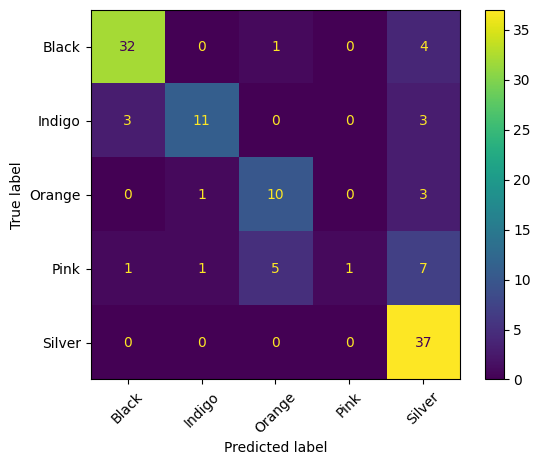

In [135]:

cm = confusion_matrix(results['true_jacket'], results['pred_jacket'], labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=45)
plt.show()


In [141]:
# Lover guitar prediction model
df['prev_lover_guitar'] = df.groupby('city')['lover_guitar'].shift(1)

# -----------------------------
# Sort and reset
# -----------------------------
df = df.sort_values('date').reset_index(drop=True)
X = df[['city', 'month', 'dayofweek', 'night_number', 'overall_show_number',
        'prev_lover_bodysuit', 'prev_lover_guitar', 'state', 'country', 'tour_leg']]
y = df['lover_guitar']

# -----------------------------
# Encode features
# -----------------------------
X = pd.get_dummies(X, columns=['city', 'state', 'country', 'prev_lover_bodysuit', 'prev_lover_guitar'], drop_first=True)

# -----------------------------
# Encode target
# -----------------------------
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# -----------------------------
# Time-based k-fold validation
# -----------------------------
n_splits = 5
dates = df['date'].sort_values().unique()
chunk_size = len(dates) // n_splits

accuracies = []

for k in range(n_splits - 1):
    # Train on chunk k, test on chunk k+1
    train_dates = dates[k*chunk_size : (k+1)*chunk_size]
    test_dates = dates[(k+1)*chunk_size : (k+2)*chunk_size]

    train_mask = df['date'].isin(train_dates)
    test_mask = df['date'].isin(test_dates)

    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y_encoded[train_mask], y_encoded[test_mask]

    # Train model
    clf = RandomForestClassifier(n_estimators=200, random_state=42)
    clf.fit(X_train, y_train)

    # Predict
    y_pred = clf.predict(X_test)

    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Fold {k+1} accuracy: {acc:.3f}")

print("Mean accuracy:", np.mean(accuracies))


Fold 1 accuracy: 0.700
Fold 2 accuracy: 0.600
Fold 3 accuracy: 0.500
Fold 4 accuracy: 0.500
Mean accuracy: 0.575


In [142]:
all_results = []

for k in range(n_splits - 1):
    # Train on chunk k, test on chunk k+1
    train_dates = dates[k*chunk_size : (k+1)*chunk_size]
    test_dates = dates[(k+1)*chunk_size : (k+2)*chunk_size]

    train_mask = df['date'].isin(train_dates)
    test_mask = df['date'].isin(test_dates)

    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y_encoded[train_mask], y_encoded[test_mask]

    # Train model
    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)

    # Predict
    y_pred = clf.predict(X_test)

    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    print(f"Fold {k+1} accuracy: {acc:.3f}")

    # -----------------------------
    # Save results for inspection
    # -----------------------------
    fold_results = pd.DataFrame({
        'fold': k+1,
        'date': df.loc[test_mask, 'date'],
        'city': df.loc[test_mask, 'city'],
        'night_number': df.loc[test_mask, 'night_number'],
        'lover_bodysuit': df.loc[test_mask, 'lover_bodysuit'],
        'true_guitar': le.inverse_transform(y_test),
        'pred_guitar': le.inverse_transform(y_pred)
    })
    fold_results['correct'] = fold_results['true_guitar'] == fold_results['pred_guitar']

    all_results.append(fold_results)

# Combine all folds
results = pd.concat(all_results, ignore_index=True)

# Filter misclassified
misclassified = results[results['correct'] == False]

print(f"Number of misclassified rows: {len(misclassified)}")
misclassified.head(62)


Fold 1 accuracy: 0.700
Fold 2 accuracy: 0.600
Fold 3 accuracy: 0.500
Fold 4 accuracy: 0.467
Number of misclassified rows: 52


,fold,date,city,night_number,lover_bodysuit,true_guitar,pred_guitar,correct
6,1,2023-06-24,Minneapolis,2,Purple Tassels,Purple,Blue,False
9,1,2023-07-07,Kansas City,1,Purple Tassels,Purple,Pink,False
10,1,2023-07-08,Kansas City,2,Pink and Blue,Blue,Pink,False
11,1,2023-07-14,Denver,1,Blue and Gold,Blue,Pink,False
12,1,2023-07-15,Denver,2,Pink and Blue,Pink,Purple,False
18,1,2023-08-04,Los Angeles,2,Pink and Blue,Purple,Blue,False
19,1,2023-08-05,Los Angeles,3,Pink and Blue,Blue,Pink,False
20,1,2023-08-07,Los Angeles,4,Blue and Gold,Blue,Pink,False
28,1,2023-11-11,Buenos Aires,2,Pink and Blue,Pink,Blue,False
32,2,2023-11-20,Rio De Janiero,3,Purple Tassels,Purple,Blue,False
